# Measuring the Distance to a Long Life  
## A Longevity Distance Index Based on Daily Time Allocation

Longevity has become one of the most critical global challenges of the 21st century, particularly in aging societies such as Japan. While medical advancements and genetics play an important role in extending life expectancy, everyday lifestyle choices — how people allocate their limited 24 hours — may be equally influential but are often discussed only in isolation. Sleep duration, working hours, or physical activity are typically analyzed as independent factors, overlooking the fact that these activities jointly form a tightly constrained system: a single day.

This notebook introduces a holistic perspective on longevity by focusing not on individual habits, but on **the structure of daily life itself**. Instead of asking whether more sleep or less work is beneficial, we ask a different question:

**How close is an individual's daily time allocation to the lifestyle patterns of long-lived people?**

To answer this, I propose a novel metric called the **Longevity Distance Index (LDI)**. The LDI measures the distance between an individual's normalized daily time allocation and the average lifestyle profile of the longest-living individuals in the dataset. A smaller distance indicates a lifestyle more similar to that of long-lived individuals, while a larger distance suggests greater deviation.

Using a dataset that records how people distribute their daily time across work, sleep, rest, and exercise — along with their age at death — this notebook demonstrates that longevity is not driven by a single behavior, but by the *balance* among competing daily activities. This framework provides a data-driven lens through which policymakers, organizations, and individuals can rethink health promotion, work-life balance, and longevity strategies in aging societies.

## Executive Summary (Key Findings)

- **Lifestyle balance matters more than individual habits.**  
  Individuals whose daily time allocation is closer to that of long-lived people live, on average, over **16 years longer** than those with the largest deviation.

- **Longevity Distance Index (LDI) captures this effect holistically.**  
  By measuring the multidimensional distance from a longevity-aligned lifestyle, LDI provides a more informative signal than any single time-use variable.

- **Model interpretability confirms LDI’s central role.**  
  Regression and SHAP analyses show that LDI consistently emerges as one of the most influential factors in explaining lifespan variation.



Longevity Lifestyle Profile (Top 10%):
avg_work_hours_per_day        0.334652
avg_rest_hours_per_day        0.301212
avg_sleep_hours_per_day       0.291645
avg_exercise_hours_per_day    0.072491
dtype: float64


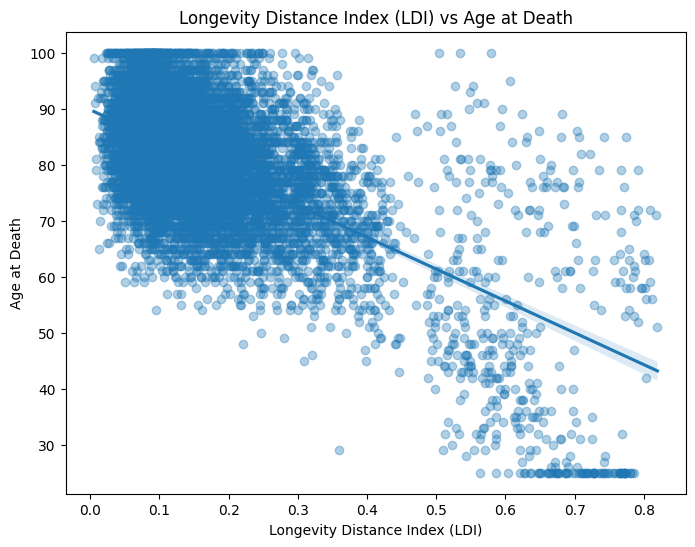

/tmp/ipykernel_17/2143437637.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df2.groupby("LDI_group")[target_col].mean().reset_index()


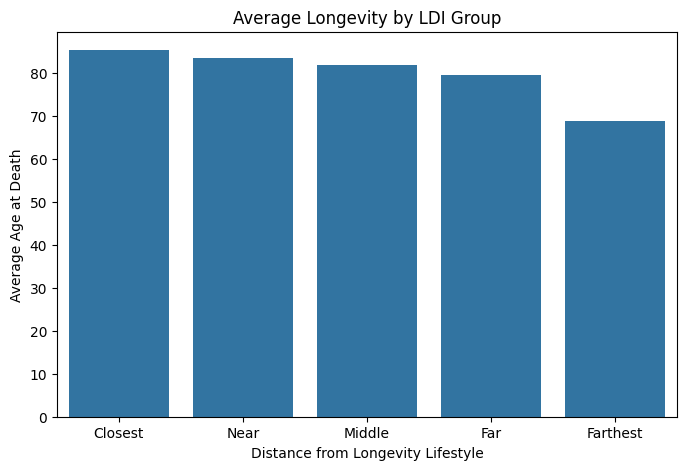

,LDI_group,age_at_death
0,Closest,85.371
1,Near,83.625
2,Middle,81.980
3,Far,79.462
4,Farthest,68.815


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm

# =========================
# 1) Load Data
# =========================
df = pd.read_csv("/kaggle/input/quality-of-life-data/Updated Quality of Life Data.csv")

# ✅ Correct column names for this dataset
time_cols = [
    "avg_work_hours_per_day",
    "avg_rest_hours_per_day",
    "avg_sleep_hours_per_day",
    "avg_exercise_hours_per_day",
]

target_col = "age_at_death"

# =========================
# 2) Normalize to "daily ratios"
#    (convert time allocation to proportions)
# =========================
df_ratio = df.copy()

row_sum = df_ratio[time_cols].sum(axis=1)

# avoid division by zero
row_sum = row_sum.replace(0, np.nan)

df_ratio[time_cols] = df_ratio[time_cols].div(row_sum, axis=0)

# =========================
# 3) Define longevity group (top 10%)
# =========================
longevity_threshold = df[target_col].quantile(0.9)
long_lived = df_ratio[df[target_col] >= longevity_threshold]

longevity_profile = long_lived[time_cols].mean()

print("Longevity Lifestyle Profile (Top 10%):")
print(longevity_profile)

# =========================
# 4) Compute Longevity Distance Index (LDI)
# =========================
df["LDI"] = df_ratio[time_cols].apply(
    lambda x: norm(x - longevity_profile), axis=1
)

# =========================
# 5) Visualization: LDI vs Longevity
# =========================
plt.figure(figsize=(8, 6))
sns.regplot(x="LDI", y=target_col, data=df, scatter_kws={"alpha": 0.35})
plt.title("Longevity Distance Index (LDI) vs Age at Death")
plt.xlabel("Longevity Distance Index (LDI)")
plt.ylabel("Age at Death")
plt.show()

# =========================
# 6) Quantile Analysis
# =========================
df2 = df.dropna(subset=["LDI", target_col]).copy()
df2["LDI_group"] = pd.qcut(df2["LDI"], 5, labels=["Closest", "Near", "Middle", "Far", "Farthest"])

grouped = df2.groupby("LDI_group")[target_col].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="LDI_group", y=target_col, data=grouped)
plt.title("Average Longevity by LDI Group")
plt.xlabel("Distance from Longevity Lifestyle")
plt.ylabel("Average Age at Death")
plt.show()

grouped

## Interim Conclusion: Lifestyle Distance and Longevity

The analyses so far provide strong evidence that the Longevity Distance Index (LDI) is closely associated with lifespan. Individuals whose daily time allocation is more similar to that of long-lived individuals consistently exhibit higher average longevity, with differences exceeding a decade between the closest and farthest groups.

At this stage, these results suggest that longevity is strongly influenced by the overall structure of daily life rather than isolated behaviors. However, an important question remains: **Is LDI merely correlated with longevity, or does it play a central and independent role when other factors are considered?**

To address this, we next examine predictive models and interpretability analyses to evaluate the robustness and explanatory power of LDI.

## Next Step

While the preceding analyses establish a clear and interpretable relationship between lifestyle distance and longevity, correlation alone does not guarantee explanatory or predictive relevance. In real-world settings, longevity is influenced by multiple interacting factors, and it is therefore essential to examine whether the Longevity Distance Index (LDI) remains meaningful when evaluated within a predictive modeling framework.

In the following sections, I extend the analysis in two complementary directions. First, I construct regression-based models to assess the extent to which LDI contributes to lifespan prediction when considered alongside other lifestyle and demographic variables. This step allows us to evaluate whether lifestyle distance provides incremental explanatory power beyond raw time-allocation measures.

Second, I apply SHAP-based model interpretability techniques to move beyond aggregate performance metrics and uncover *how* and *why* LDI influences predicted longevity at the individual level. By decomposing model predictions into feature-level contributions, SHAP analysis enables me to distinguish structural lifestyle effects from spurious correlations and to verify whether deviations from longevity-aligned daily routines systematically reduce predicted lifespan.

Together, these analyses serve as a robustness check and an interpretability layer, transforming the Longevity Distance Index from a descriptive metric into a validated explanatory construct for understanding human longevity.


In [2]:
from numpy.linalg import norm

# ---- Ratio features (time allocation as proportions)
df_ratio = df.copy()
row_sum = df_ratio[time_cols].sum(axis=1).replace(0, np.nan)
df_ratio[time_cols] = df_ratio[time_cols].div(row_sum, axis=0)

# ---- Longevity profile (top 10%)
longevity_threshold = df[target_col].quantile(0.9)
long_lived = df_ratio[df[target_col] >= longevity_threshold]
longevity_profile = long_lived[time_cols].mean()

# ---- LDI
df["LDI"] = df_ratio[time_cols].apply(lambda x: norm(x - longevity_profile), axis=1)

# ---- Optional categorical columns (存在する場合だけ使う)
cat_candidates = ["gender", "occupation_type"]
cat_cols = [c for c in cat_candidates if c in df.columns]

# ---- Build modeling dataframe
feature_cols = time_cols + ["LDI"] + cat_cols

data = df_ratio.copy()
data["LDI"] = df["LDI"]
data[target_col] = df[target_col]

# カテゴリ列も付与（元のdfから）
for c in cat_cols:
    data[c] = df[c]

# 欠損除去
data_model = data.dropna(subset=feature_cols + [target_col]).copy()

print("Using categorical columns:", cat_cols)
print("Modeling rows:", len(data_model))


Using categorical columns: ['gender', 'occupation_type']
Modeling rows: 10000


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

X = data_model[feature_cols]
y = data_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 前処理：カテゴリはOneHot、数値はそのまま
numeric_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# ---- 1) Linear model (Ridge)
ridge_model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0))
])

ridge_model.fit(X_train, y_train)
pred_ridge = ridge_model.predict(X_test)

print("=== Ridge Regression ===")
print("MAE:", mean_absolute_error(y_test, pred_ridge))
print("R2 :", r2_score(y_test, pred_ridge))


=== Ridge Regression ===
MAE: 6.6694354939072955
R2 : 0.5364151992822321


In [4]:
# =========================
# XGBoost availability check
# =========================
use_xgb = True
try:
    import xgboost as xgb
except Exception as e:
    use_xgb = False
    print("xgboost not available -> fallback to sklearn GradientBoostingRegressor")


In [5]:
from sklearn.ensemble import GradientBoostingRegressor

if use_xgb:
    xgb_model = Pipeline(steps=[
        ("prep", preprocess),
        ("model", xgb.XGBRegressor(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.0,
            reg_lambda=1.0,
            random_state=42
        ))
    ])
    xgb_model.fit(X_train, y_train)
    pred_xgb = xgb_model.predict(X_test)
    print("=== XGBoost Regressor ===")
    print("MAE:", mean_absolute_error(y_test, pred_xgb))
    print("R2 :", r2_score(y_test, pred_xgb))
else:
    gbr_model = Pipeline(steps=[
        ("prep", preprocess),
        ("model", GradientBoostingRegressor(random_state=42))
    ])
    gbr_model.fit(X_train, y_train)
    pred_gbr = gbr_model.predict(X_test)
    print("=== GradientBoostingRegressor ===")
    print("MAE:", mean_absolute_error(y_test, pred_gbr))
    print("R2 :", r2_score(y_test, pred_gbr))


=== XGBoost Regressor ===
MAE: 6.440255641937256
R2 : 0.570899486541748


In [6]:
# 前処理後の feature matrix を取り出すためのヘルパ
def get_transformed_feature_names(preprocess, numeric_cols, cat_cols):
    names = []
    # numeric
    names.extend(numeric_cols)
    # categorical
    if len(cat_cols) > 0:
        ohe = preprocess.named_transformers_["cat"]
        cat_names = list(ohe.get_feature_names_out(cat_cols))
        names.extend(cat_names)
    return names

# preprocessはPipeline内の "prep"
# 学習済みモデル（xgb_model or gbr_model）から取り出す
trained_pipe = xgb_model if use_xgb else gbr_model
prep_fitted = trained_pipe.named_steps["prep"]

X_test_trans = prep_fitted.transform(X_test)
feature_names = get_transformed_feature_names(prep_fitted, numeric_cols, cat_cols)

print("Transformed shape:", X_test_trans.shape)
print("Num features:", len(feature_names))
print("Example feature names:", feature_names[:10])


Transformed shape: (2000, 21)
Num features: 21
Example feature names: ['avg_work_hours_per_day', 'avg_rest_hours_per_day', 'avg_sleep_hours_per_day', 'avg_exercise_hours_per_day', 'LDI', 'gender_Female', 'gender_Male', 'occupation_type_Artist', 'occupation_type_Consultant', 'occupation_type_Driver']


To validate whether LDI plays a central role beyond simple correlation, I apply SHAP-based model interpretation. 

X_test_trans_df: (2000, 21)
TreeExplainer(booster) failed -> fallback to PermutationExplainer. Error: could not convert string to float: '[7.987325E1]'


PermutationExplainer explainer: 301it [00:41,  6.17it/s]


SHAP: PermutationExplainer succeeded.


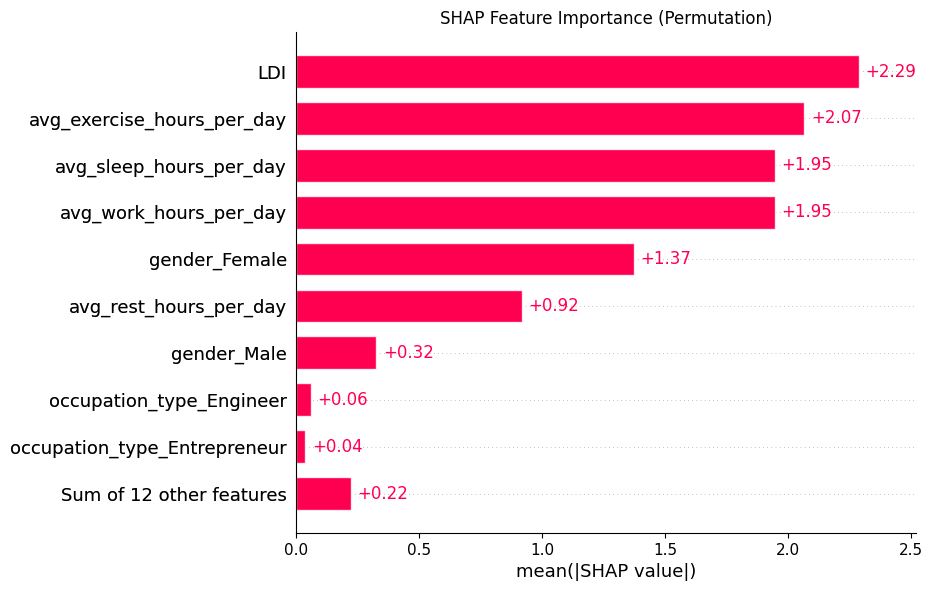

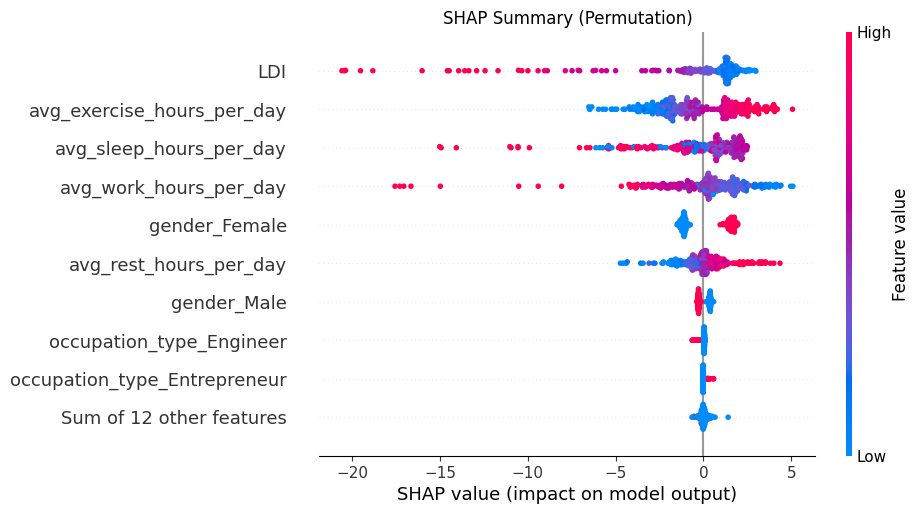

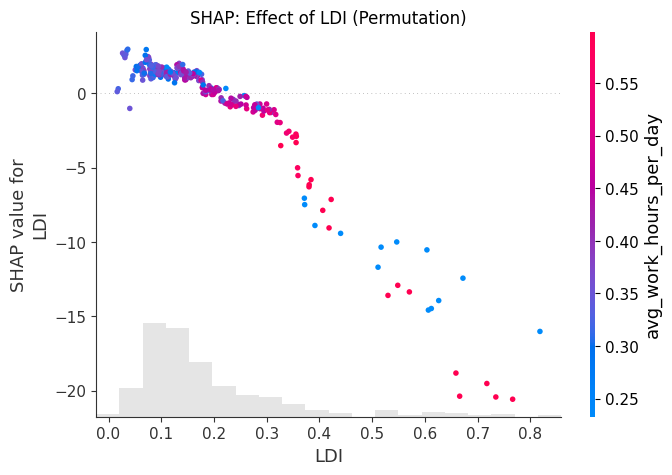

In [7]:
import shap
import matplotlib.pyplot as plt

# ===== 1) get preprocess + model
prep = trained_pipe.named_steps["prep"]
model_core = trained_pipe.named_steps["model"]

# ===== 2) transform X_test -> DataFrame
X_test_trans = prep.transform(X_test)

# feature names を安全に作る（ColumnTransformer前提）
def get_feature_names_from_column_transformer(ct):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "num":
            names.extend(list(cols))
        elif name == "cat":
            # OneHotEncoder
            ohe = trans
            names.extend(list(ohe.get_feature_names_out(cols)))
    return names

feature_names = get_feature_names_from_column_transformer(prep)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names)

print("X_test_trans_df:", X_test_trans_df.shape)

# ===== 3) SHAP (try TreeExplainer with Booster first)
shap_values = None

try:
    booster = model_core.get_booster()  # XGBRegressor -> Booster
    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_test_trans_df)
    print("SHAP: TreeExplainer(booster) succeeded.")
except Exception as e:
    print("TreeExplainer(booster) failed -> fallback to PermutationExplainer. Error:", e)

    # fallback (robust but slower) - sample to speed up
    X_shap = X_test_trans_df.sample(min(300, len(X_test_trans_df)), random_state=42)

    def f_predict(X):
        # X is a DataFrame with transformed features
        return model_core.predict(X.values)

    explainer = shap.PermutationExplainer(f_predict, X_shap)
    shap_exp = explainer(X_shap)
    print("SHAP: PermutationExplainer succeeded.")

    # bar + beeswarm (new API)
    shap.plots.bar(shap_exp, show=False)
    plt.title("SHAP Feature Importance (Permutation)")
    plt.show()

    shap.plots.beeswarm(shap_exp, show=False)
    plt.title("SHAP Summary (Permutation)")
    plt.show()

    # LDI plot if present
    if "LDI" in X_shap.columns:
        shap.plots.scatter(shap_exp[:, "LDI"], color=shap_exp, show=False)
        plt.title("SHAP: Effect of LDI (Permutation)")
        plt.show()

# ===== 4) If TreeExplainer path succeeded: use classic summary plots
if shap_values is not None:
    # Bar
    shap.summary_plot(shap_values, X_test_trans_df, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (XGBoost Booster)")
    plt.show()

    # Beeswarm
    shap.summary_plot(shap_values, X_test_trans_df, show=False)
    plt.title("SHAP Summary (XGBoost Booster)")
    plt.show()

    # LDI dependence
    if "LDI" in X_test_trans_df.columns:
        shap.dependence_plot("LDI", shap_values, X_test_trans_df, show=False)
        plt.title("SHAP Dependence: LDI")
        plt.show()
    else:
        print("LDI not found in transformed feature names.")

In [8]:
# LDI group（あなたの結果と同じ5分位）
df_plot = data_model.copy()
df_plot["LDI"] = df.loc[df_plot.index, "LDI"]

df_plot = df_plot.dropna(subset=["LDI", target_col]).copy()
df_plot["LDI_group"] = pd.qcut(df_plot["LDI"], 5, labels=["Closest", "Near", "Middle", "Far", "Farthest"])

# グループ平均（比率）
group_mean = df_plot.groupby("LDI_group")[time_cols].mean()

# Longevity profile（比率）も入れる
longevity_profile_ratio = longevity_profile.copy()  # すでに比率で計算済み

display(group_mean)
print("\nLongevity profile ratio:")
print(longevity_profile_ratio)


/tmp/ipykernel_17/115740175.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mean = df_plot.groupby("LDI_group")[time_cols].mean()


,avg_work_hours_per_day,avg_rest_hours_per_day,avg_sleep_hours_per_day,avg_exercise_hours_per_day
LDI_group,,,,
Closest,0.341104,0.297105,0.295063,0.066728
Near,0.350683,0.290663,0.302500,0.056154
Middle,0.364643,0.272908,0.305495,0.056954
Far,0.397840,0.216687,0.321137,0.064336
Farthest,0.464848,0.165203,0.310012,0.059938



Longevity profile ratio:
avg_work_hours_per_day        0.334652
avg_rest_hours_per_day        0.301212
avg_sleep_hours_per_day       0.291645
avg_exercise_hours_per_day    0.072491
dtype: float64


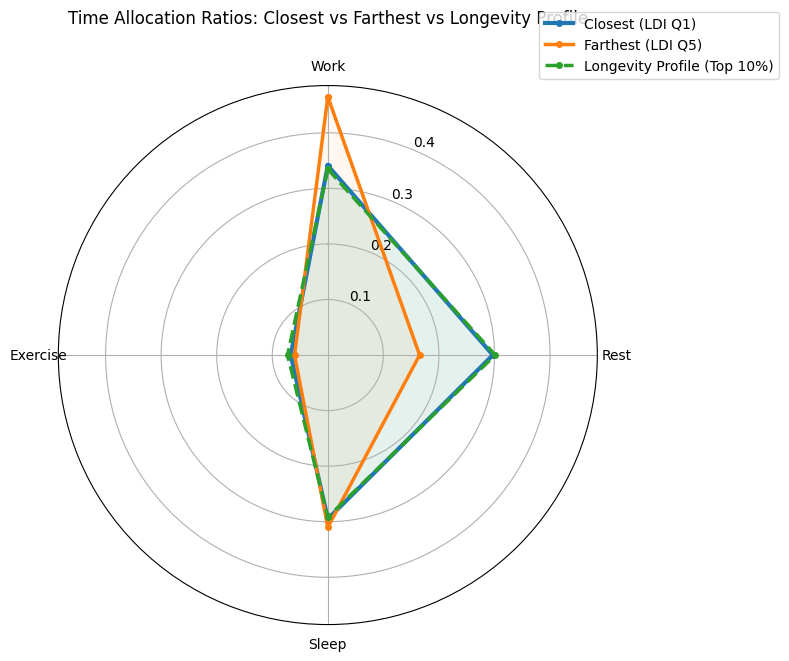

In [9]:
labels = ["Work", "Rest", "Sleep", "Exercise"]

def radar(values_dict, title="Radar Chart: Time Allocation Ratios"):
    categories = labels
    N = len(categories)

    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)

    # ① 塗りを先に描く（下層）
    for name, s in values_dict.items():
        vals = [float(s[c]) for c in time_cols]
        vals += vals[:1]
        ax.fill(angles, vals, alpha=0.06, zorder=1)

    # ② 線を後で描く（上層）
    for name, s in values_dict.items():
        vals = [float(s[c]) for c in time_cols]
        vals += vals[:1]

        # Longevity Profile は破線にする（上書き問題の回避にも効く）
        ls = "--" if "Longevity Profile" in name else "-"
        lw = 3 if "Closest" in name else 2.5

        ax.plot(angles, vals, linewidth=lw, linestyle=ls, marker="o", markersize=4, zorder=3, label=name)

    ax.set_title(title, y=1.10)
    ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.15))
    plt.show()

values_dict = {
    "Closest (LDI Q1)": group_mean.loc["Closest"],
    "Farthest (LDI Q5)": group_mean.loc["Farthest"],
    "Longevity Profile (Top 10%)": longevity_profile_ratio
}

radar(values_dict, title="Time Allocation Ratios: Closest vs Farthest vs Longevity Profile")



## Final Conclusion & Implications

By combining distance-based lifestyle analysis with model interpretability techniques, this study demonstrates that the Longevity Distance Index (LDI) is not only correlated with lifespan but also emerges as one of the most influential explanatory features in predictive models.

SHAP analysis confirms that deviations from longevity-aligned daily time allocation systematically reduce predicted lifespan, reinforcing the idea that longevity is a function of *how daily activities are balanced*, not simply the presence or absence of individual healthy habits.

These findings have direct implications for aging societies such as Japan. Rather than prescribing uniform behavioral targets, policies and workplace interventions may benefit from focusing on **reducing lifestyle distance** — enabling individuals to gradually realign their daily routines toward proven longevity patterns. This reframing transforms longevity from an abstract ideal into a measurable, actionable objective grounded in everyday life.


Thank you!